In [1]:
# --------------------  Imports  -----------------------

import openpmd_api as io
from mpi4py import MPI
import numpy as np
import sys
# ------------------------------------------------------
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import matplotlib.animation
# import scipy as scp
import scipy.stats as scSt
# import scipy.fft as fft
import scipy.fftpack as fft
from math import pi
from scipy.constants import speed_of_light as C
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.optimize import curve_fit

In [21]:

# --------------------  Functions  -----------------------

def getData(E, var='x'):
    E_var = E[var]
    var_unit = E_var.unit_SI
    var_data = E_var.load_chunk()
    series.flush()
    var_data *= var_unit
    return var_data

# Returns max_value & its indexes from 3D array
def getMaxVal3D(data):
    ax_max = data.max()
    [ax_max_ind1, ax_max_ind2, ax_max_ind3]  = np.where(data == ax_max)
    return ax_max, ax_max_ind1[0], ax_max_ind2[0], ax_max_ind3[0]


def getEnvelope(data):
    an_data = hilbert(data)
    amp_env_ax = np.abs(an_data)
    return amp_env_ax


def doOneIterStream(Ex_data, mode = 1):
    """mode 1: Y axis - single iter of Envelope data in To Massive with highest E_[x,y,z] value 
       mode 2: X axis - single iter of Envelope data in To Massive with highest E_[x,y,z] value (From Y axis Values).""" 
    
    Ex_env = np.abs(hilbert(Ex_data, axis=1))
#     plt.imshow(Ex_env[64,:,:], aspect = 'auto')
#     plt.show()

#     plt.imshow(Ex_env[:,:,64], aspect = 'auto')
#     plt.show()

    
    [Ex_env_max, Ex_env_max_ind_xAx, Ex_env_max_ind_yAx, Ex_env_max_ind_zAx] = getMaxVal3D(Ex_env)
    

    if mode == 1:
        return Ex_env[Ex_env_max_ind_xAx, :, Ex_env_max_ind_zAx] #, Ey_data[Ey_max_ind_xAx, :, Ey_max_ind_zAx], Ez_data[Ez_max_ind_xAx, :, Ez_max_ind_zAx]        
    else:
        [Ex_env_max_ind_xAx, Ex_env_max_ind_zAx] = getMaxValForX(Ex_env, Ex_env_max_ind_yAx)
            
        
        return Ex_env[:, Ex_env_max_ind_yAx, Ex_env_max_ind_zAx] #, Ey_env[:, Ey_max_ind_yAx, Ey_max_ind_zAx], Ez_env[:, Ey_max_ind_zAx, Ez_max_ind_zAx]        

    

def getThreshold():
    run_num = 70  # This may change, Now it's considered that values doesn't change much from run to run
    peak_coef = 0.05  # this May Change (needs manipulation)

    dist_Mode = np.array(scSt.mode(Ex_env_yAx[run_num]))  # Ex_env_yAx araa agwerili aq da gadaxede kargad!!!!

    filt_threshold_mode = dist_Mode[0]
    # print('mode thresh ', filt_threshold_mode)
    filt_threshold_mode = np.round(filt_threshold_mode+5e-05, 7)
    # print('mode thresh round ', filt_threshold_mode)
    filt_threshold_peak = Ex_env_yAx.max()*peak_coef
    # print('mode thresh peak ', filt_threshold_peak)
    filt_threshold = (filt_threshold_peak + filt_threshold_mode)/2
    # print(filt_threshold)
    
    return filt_threshold
    
    
def env_filter(env_dat, filt_threshold, it_size):
    env_filtered = []
    for r_n in range(it_size):
        tmp_dat = env_dat[r_n][env_dat[r_n] > filt_threshold]
        env_filtered.append(tmp_dat)
    return env_filtered
    

def getSkews(data, it_size):
    skew_mass = []
    for it in range(it_size):
        skew_mass.append(scSt.skew(data[it]))
    return skew_mass
    
    
    
def getFWHM(env_data):
    env_max = env_data.max()
    env_max_ind = np.where(Ix_yAx_arr[10]==Ix_yAx_arr[10].max())[0][0]
    
    r_half_val = env_max/2
    
    half_val_1 = 0
    half_val_1_index = 0
    
    half_val_2 = 0
    half_val_2_index = 0
    
    #for first mid-point (going up)
    for i in range(len(env_data)):
        if env_data[i] >= r_half_val:
            if (r_half_val - env_data[i-1]) < (env_data[i] - r_half_val):
                half_val_1 = env_data[i-1]
                half_val_1_index = i-1
            else:
                half_val_1 = env_data[i]
                half_val_1_index = i
            break

    #for second mid-point (going down)
    for i in range(env_max_ind, len(env_data)):
        if env_data[i] <= r_half_val:
            if (r_half_val - env_data[i]) < (env_data[i-1] - r_half_val):
                half_val_2 = env_data[i]
                half_val_2_index = i
            else:
                half_val_2 = env_data[i-1]
                half_val_2_index = i-1
            break
            
    return half_val_2_index - half_val_1_index


    
def doFft(data, data_size, dy):
    # Generate frequency axis
#     int(pi*C/dy)
    fr = pi*C/dy * np.linspace(0,1, int(data_size/2))
    #Compute FFT
    data_f = fft.fft(data)
    data_f_magn = abs(data_f[0:np.size(fr)])
    
    return fr, data_f_magn


def getIntensity(data, isNumpy = False, v = C):
    n = C/v #Refractive index
    
    eps = 8.854e-12
    
    dat_I = []
    
    if isNumpy: # works for N dimensional numpy
        dat_I = C*n*eps/2*np.square(data)
    else: #only works for one dimensional list
        for i in range(len(data)):
            dat_I.append(C*n*eps/2*data[i]**2)
    
    return dat_I
    
    
# def getEnvMaxs(data):
#     result = []
#     for i in range(len(data)):
#         if(len(data[i]) == 0):
#             result.append(0)
#         else:
#             tmpMax = np.amax(np.array(data[i]))
#             result.append( tmpMax )
#     return result    


def getEnvMaxs(data):
    result = []
    result_ind = []
    for i in range(len(data)):
        if(len(data[i]) == 0):
            result.append(0)
            result_ind.append(0)
        else:
            tmpMax = np.amax(np.array(data[i]))
            tmpMax_ind = np.argmax(np.array(data[i]))
            result.append( tmpMax )
            result_ind.append(tmpMax_ind)
    return result, result_ind
    

    
def getMaxValForX(data, yIndex):
    data_slised = data[:,yIndex,:]
    
    ax_max = np.max(data_slised)
    [ax_max_xAx, ax_max_zAx]  = np.where(data_slised == ax_max)

    return ax_max_xAx[0], ax_max_zAx[0]


def gausFunc(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

In [3]:
# ----------------------- Global Variables ---------------------------

firstDataIn = False

# Iterations along the 'y' axis of the box when E[x,y,z] has max value in it on some iteration
Ex_yAx_arr = []
Ey_yAx_arr = []
Ez_yAx_arr = []

# Iterations along the 'y' axis of the box when I[x,y,z] has max value in it on some iteration
Ix_yAx_arr = []
Iy_yAx_arr = []
Iz_yAx_arr = []

# x axes data surface along the all iterations (Evolution over time)
Ex_xAx_arr = []
Ey_xAx_arr = []
Ez_xAx_arr = []
# For intensity
Ix_xAx_arr = []
Ix_xAx_arr = []
Ix_xAx_arr = []

# Filtered Envelope data
Ex_env_yAx_filt = []
Ey_env_yAx_filt = []
Ez_env_yAx_filt = []

# Pulse Duration - all iterations array
puls_dur_x = []
puls_dur_y = []
puls_dur_z = []

# Fast Furier Transform Array of Each Iteration
fft_fr_arr = []
fft_data_arr = []
# FFT Main Frequency Iteration's Array
fft_fr_max_arr = []
# FFT-freq Generate Wavelengths
fft_wl = []

# Number of iterations / Not really used, it's more like the maximum iteration size
iterations_size = 700

# Number of cells on y axis
cells_y_size = 768

# Animation vertical border parameter 
anim_ver_brdr = 1.05

# Iteration step
iter_step = 100

# First iteration, where pulse is fully inside the cell
it_num_strt = 7

# Array of iterations when the laser is fully inside the box
seriesIter_loc = np.linspace(it_num_strt, iterations_size-1, iterations_size-it_num_strt)*iter_step

# Dimension Conversion Coefficients - Changed in the specific window
cell_x_coef = 1
cell_y_coef = 1
cell_z_coef = 1
time_coef = 1
time_arr = np.array([])

# Array for plotting using X and Z axis in Meters
x_axis_arr = []
z_axis_arr = []

# The distance to the laser focus in y-direction
FOCUS_POS_SI = 4.62e-5

# Waist Radius
W0_SI = 5.0e-6 / 1.17741

I0 = 1

conv_units_set = False

In [4]:
# ----------------------- Setup Streaming ---------------------------

inseries = io.Series("/bigdata/hplsim/scratch/lomidz10/runs/lwfa_stream_002C/simOutput/openPMD/stream.sst", \
                     io.Access_Type.read_only, MPI.COMM_WORLD, '{}')

Conv Param Set
iteration -  0


/trinity/shared/pkg/devel/python/3.6.5/lib/python3.6/site-packages/scipy/signal/signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


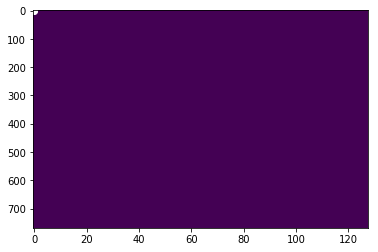

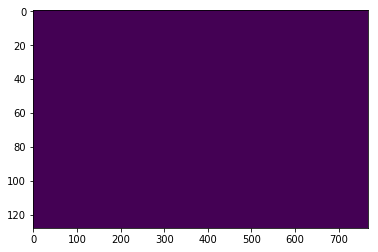

warning 0
iteration -  1


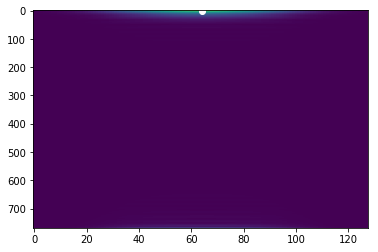

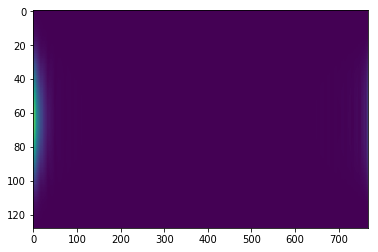

iteration -  2


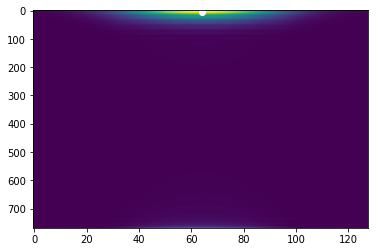

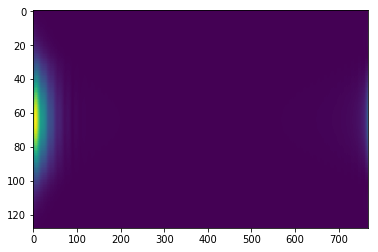

iteration -  3


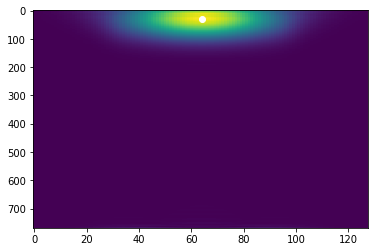

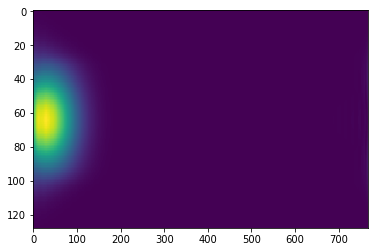

iteration -  4


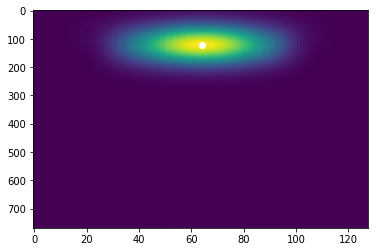

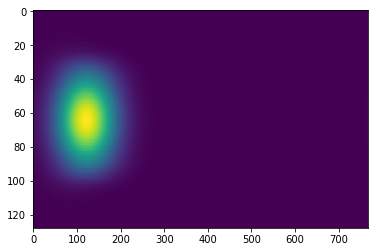

iteration -  5


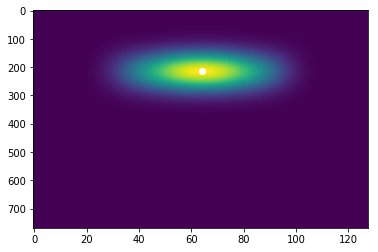

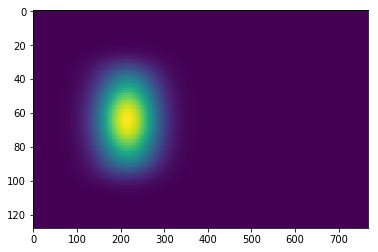

iteration -  6


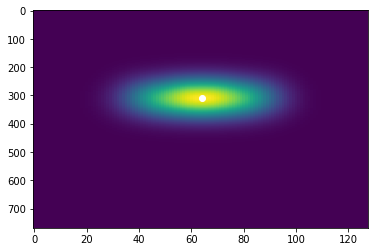

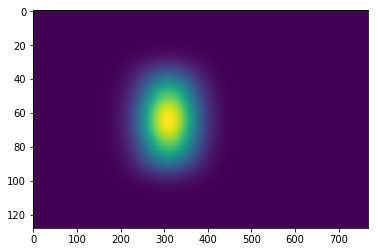

iteration -  7


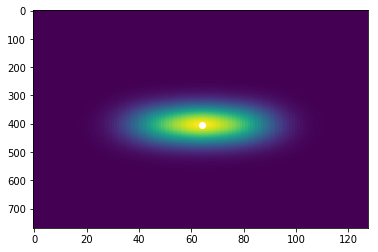

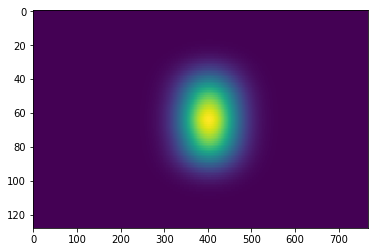

iteration -  8


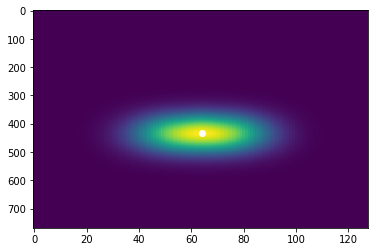

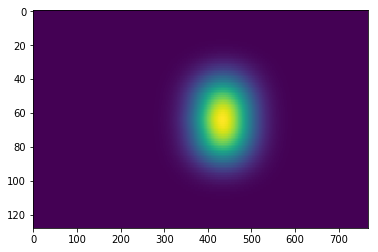

iteration -  9


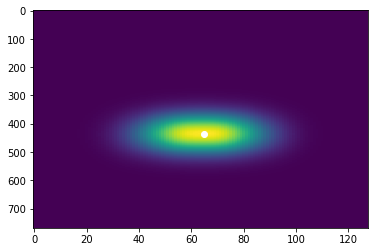

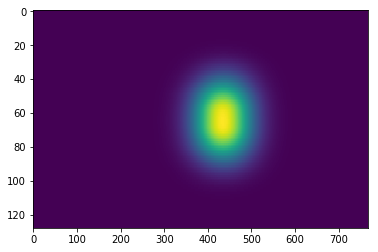

iteration -  10


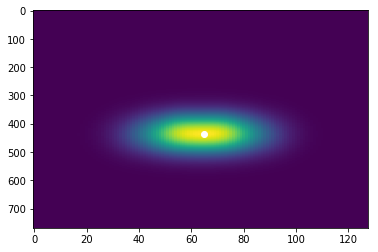

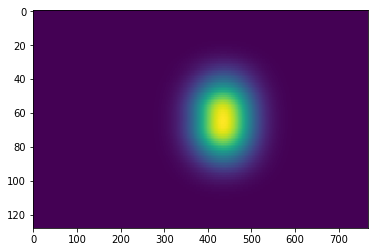

iteration -  11


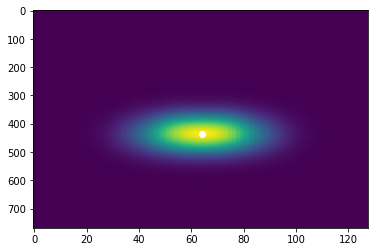

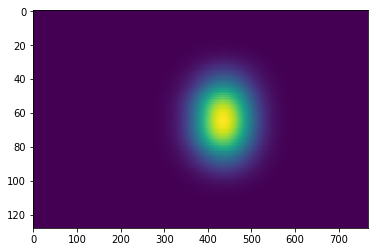

iteration -  12


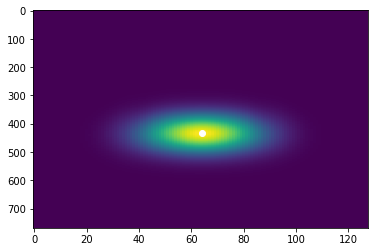

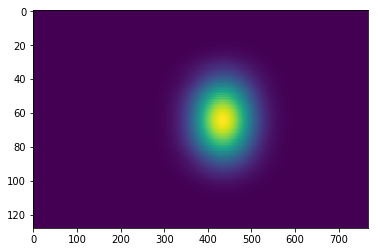

iteration -  13


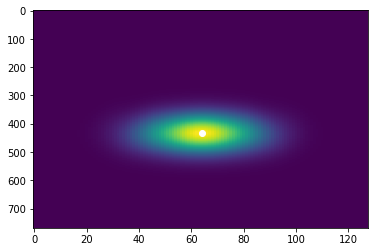

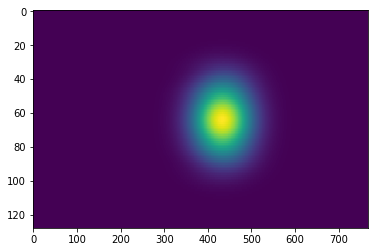

iteration -  14


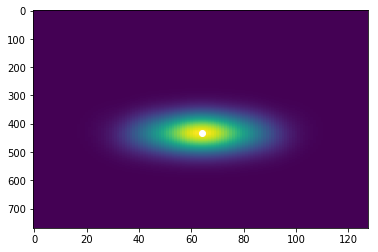

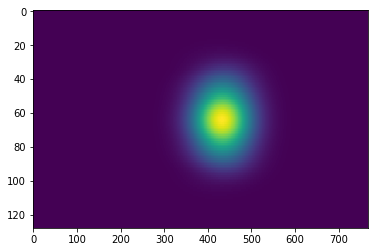

iteration -  15


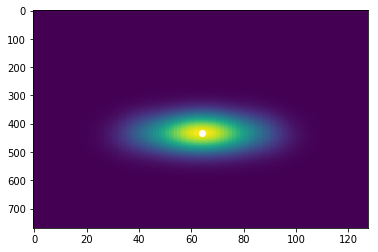

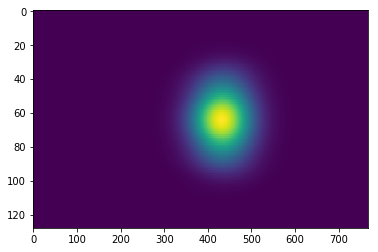

iteration -  16


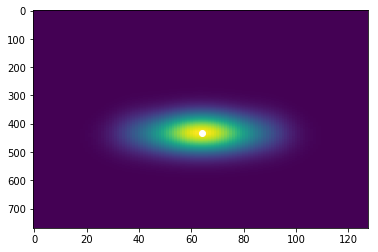

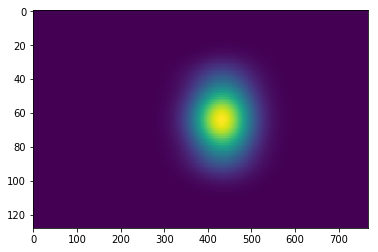

iteration -  17


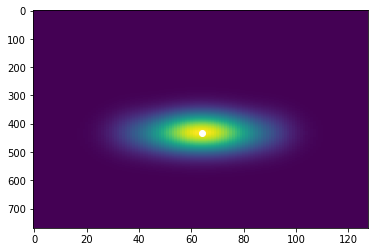

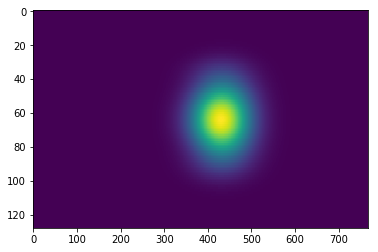

iteration -  18


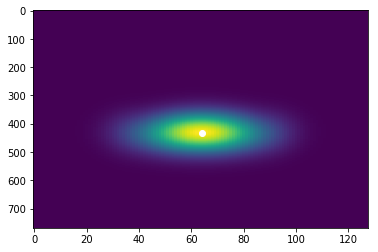

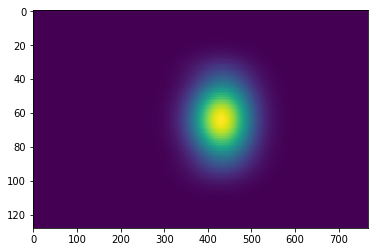

iteration -  19


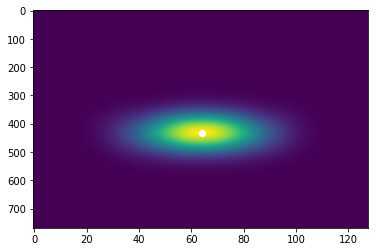

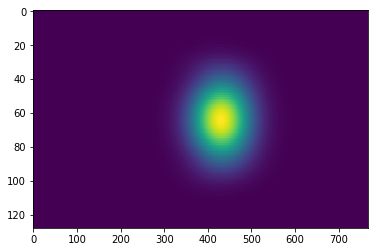

iteration -  20


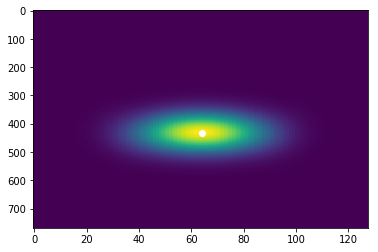

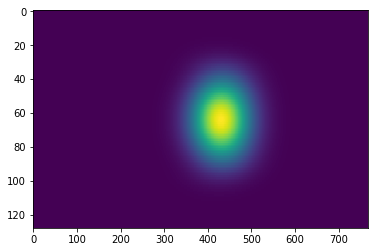

iteration -  21


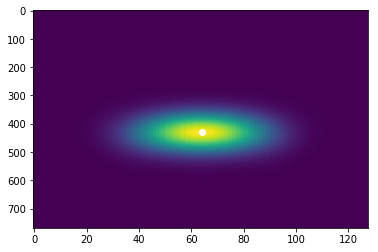

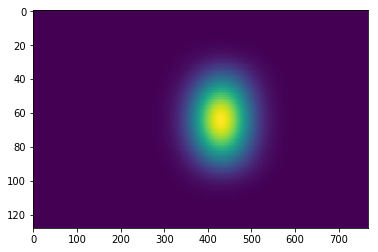

iteration -  22


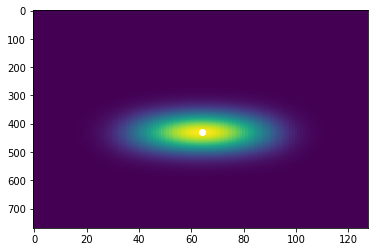

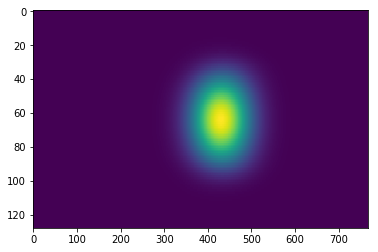

iteration -  23


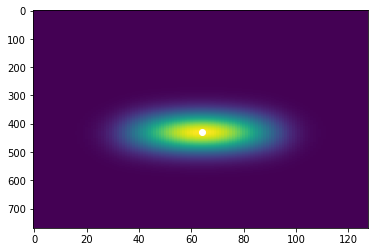

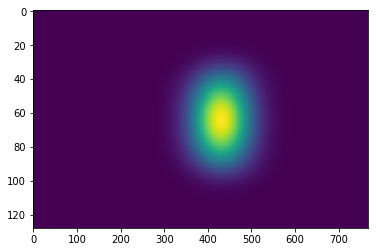

iteration -  24


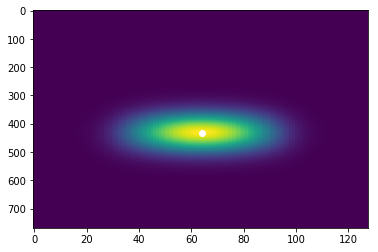

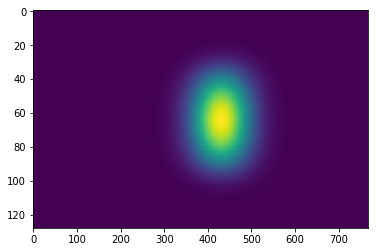

iteration -  25


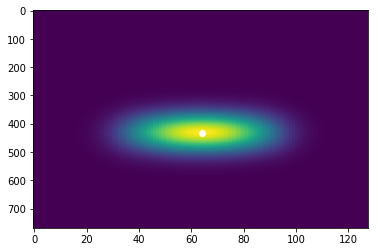

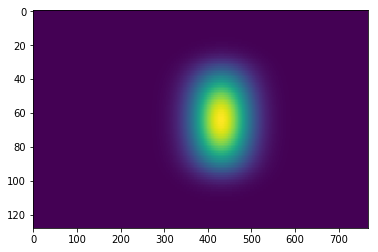

iteration -  26


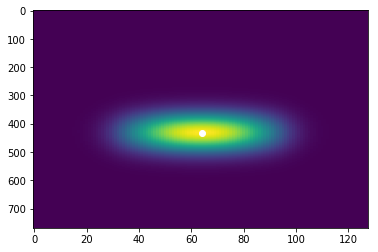

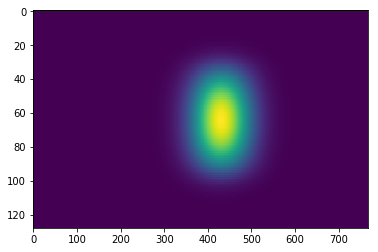

iteration -  27


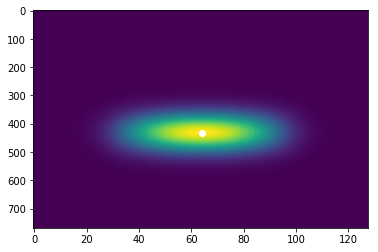

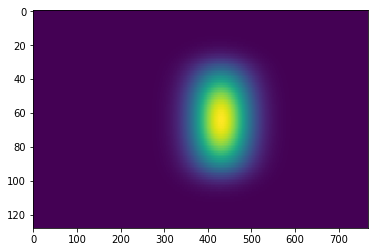

iteration -  28


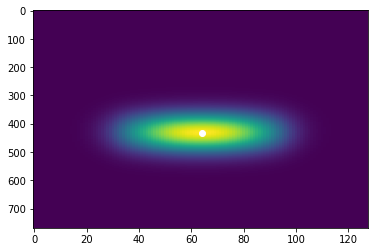

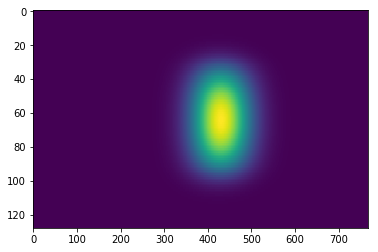

iteration -  29


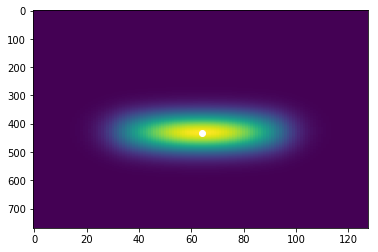

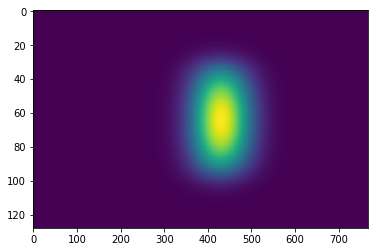

iteration -  30


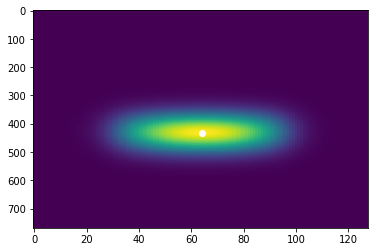

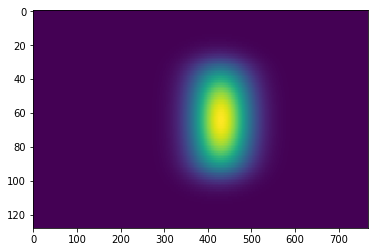

iteration -  31


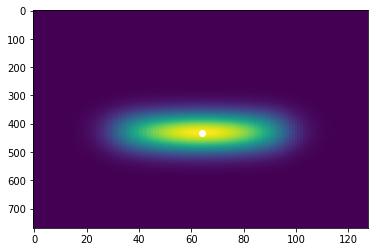

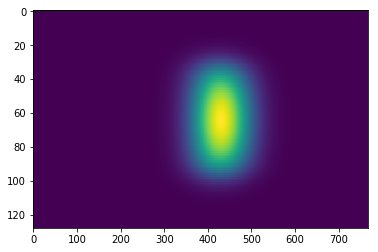

iteration -  32


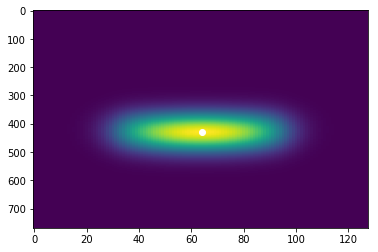

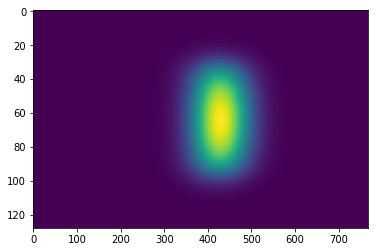

iteration -  33


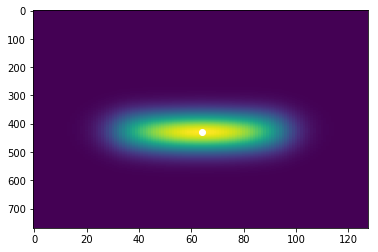

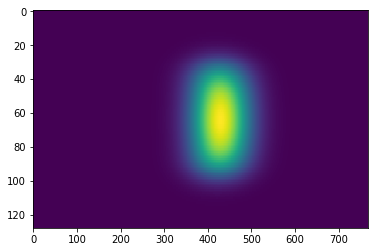

iteration -  34


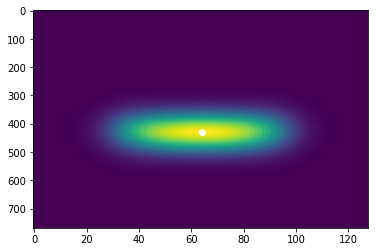

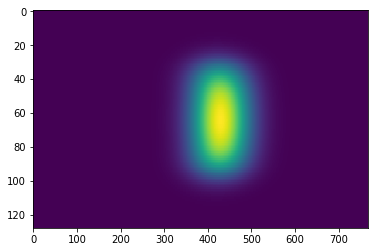

iteration -  35


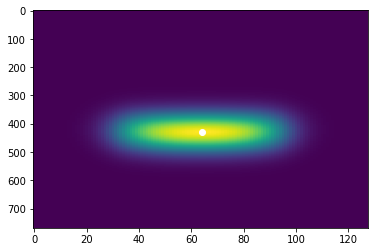

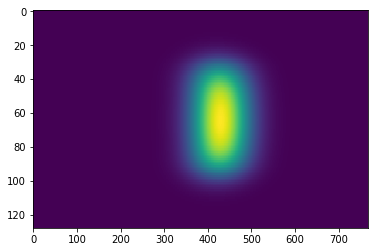

iteration -  36


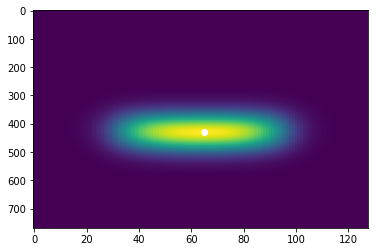

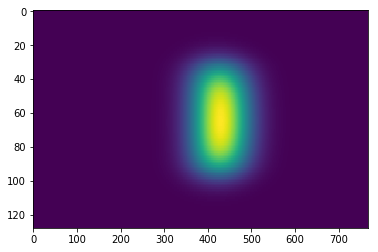

iteration -  37


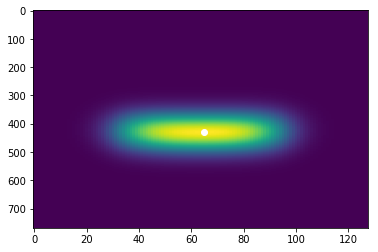

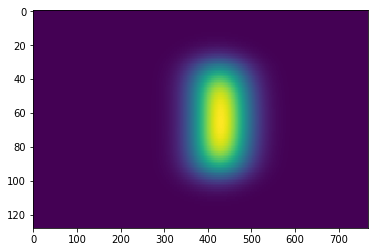

iteration -  38


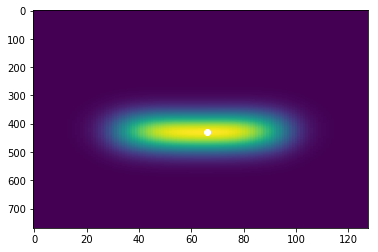

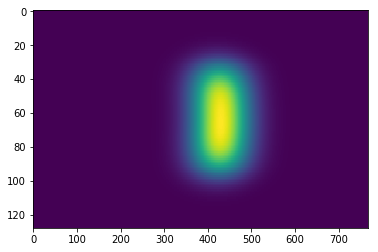

iteration -  39


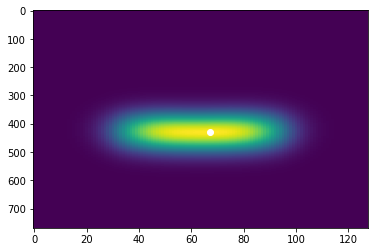

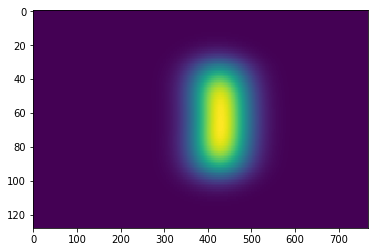

warning 67
iteration -  40


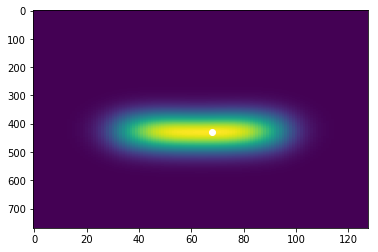

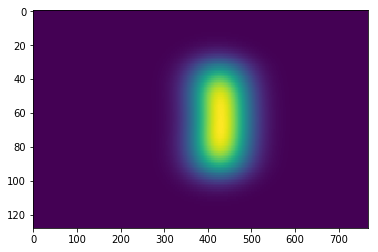

warning 68


In [5]:
# For Fast Testint
iterations_we_want_to_do = iterations_size
# iterations_we_want_to_do = 14

iterations_done_so_far = 0

for it in inseries.read_iterations():
    if iterations_done_so_far == iterations_we_want_to_do:
        break
    
    # SI Unit conversion Part
    if not(conv_units_set):
        cell_x_coef = it.get_attribute('cell_width')*it.get_attribute('unit_length')
        cell_y_coef = it.get_attribute('cell_height')*it.get_attribute('unit_length')
        cell_z_coef = it.get_attribute('cell_depth')*it.get_attribute('unit_length')
        time_coef = it.get_attribute('timeUnitSI')
        conv_units_set = True
        print('Conv Param Set')
        
    it_index = it.iteration_index
    E = it.meshes["E"]
    E_unitDim = E.unit_dimension
            
    Ex = E["x"]
    x_unit = Ex.unit_SI
    extent = Ex.shape            
    Ex_data = Ex.load_chunk([0], Ex.shape)
        
    # Get time Array
    time_arr = np.append(time_arr, it.get_attribute('time')*time_coef)
    
    it.close()
    sys.stdout.flush()


    Ex_data = Ex_data * x_unit
    
    print("iteration - ", iterations_done_so_far)
    
    Ex_yAx_it = doOneIterStream(Ex_data)
    Ex_xAx_it = doOneIterStream(Ex_data, 2)
    
    if not(firstDataIn):
        Ex_yAx_arr = np.array([Ex_yAx_it])
        Ex_xAx_arr = np.array([Ex_xAx_it])

        firstDataIn = True
    else:
        Ex_yAx_arr = np.append(Ex_yAx_arr, [Ex_yAx_it], axis=0)
        Ex_xAx_arr = np.append(Ex_xAx_arr, [Ex_xAx_it], axis=0)
        
    iterations_done_so_far += 1
    
    
    # ----------------------------------------------------------------------------
    
    
    

In [6]:
# ----------------------- Print Iterations ----------------------------------

print("iterations done - ", iterations_done_so_far)

iterations done -  41


In [7]:
# ----------------------- Get Intensity Data ----------------------------------

Ix_yAx_arr = np.array(getIntensity(Ex_yAx_arr))
Ix_xAx_arr = np.array(getIntensity(Ex_xAx_arr))

In [8]:
# ---------- Get Interation(array) Max Values of Raw Data on y axis ------------

Ex_max_yAx_arr = np.amax(Ex_yAx_arr,axis=1)



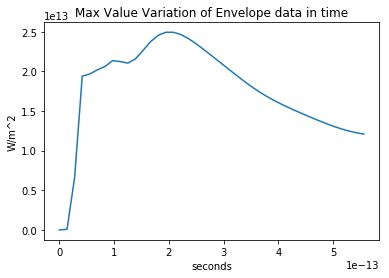

In [9]:
# ---------- Plot Max Value Variation of Envelope data in time ------------

fig1, ax1 = plt.subplots()

ax1.set_title("Max Value Variation of Envelope data in time")
ax1.set_xlabel('seconds')                             
ax1.set_ylabel('W/m^2')
ax1.plot(time_arr, Ex_max_yAx_arr)

Text(0, 0.5, 'seconds')

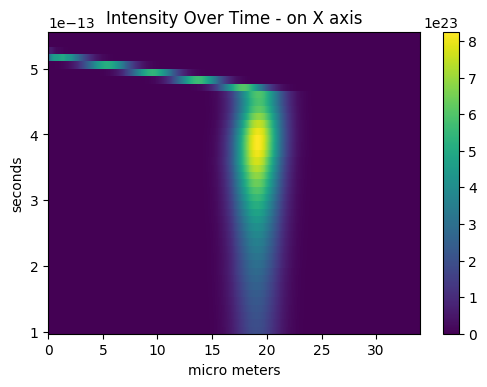

In [68]:
# ---------- Plot Intensity over Y axis -------------

plt.figure( dpi = 100)
plt.imshow(Ix_yAx_arr, aspect = 'auto', extent=[0, Ix_yAx_arr.shape[1]*cell_y_coef*1e6, time_arr[it_num_strt], time_arr[-1]])
plt.title("Intensity Over Time - on X axis")
plt.colorbar()
plt.xlabel("micro meters")
plt.ylabel("seconds")



In [10]:
# ---------------- Skewness Finder --------------------

div_line_skew = np.linspace(0,0, iterations_done_so_far)

skew_Ix_Mass = np.array(getSkews(Ix_yAx_arr[it_num_strt:], iterations_done_so_far-it_num_strt))


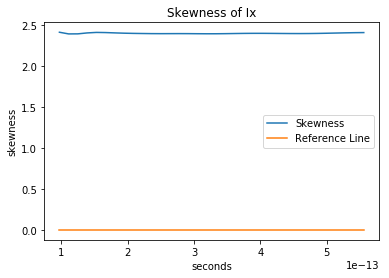

In [11]:
# --------------- Plot Skewness Dist -------------------

plt.plot(time_arr[it_num_strt:], skew_Ix_Mass)
plt.plot(time_arr[it_num_strt:], div_line_skew[it_num_strt:])
plt.title('Skewness of Ix')
plt.xlabel('seconds')
plt.ylabel('skewness')
plt.legend(['Skewness', 'Reference Line'])

Text(0, 0.5, 'meters')

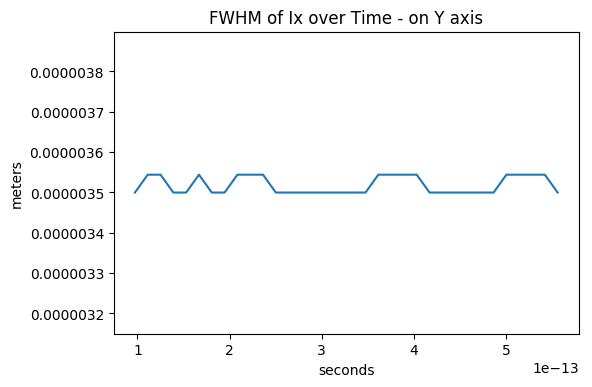

In [12]:
# ---------------- Full Width Half Maximum (FWHM) of I[x,y,z] over time along the Y Axis --------------------

fwhm_x_arr = []

# for it in range(it_num_strt, iterations_size):
for it in range(it_num_strt, iterations_done_so_far):  
    if(len(Ix_yAx_arr[it]) == 0):
        fwhm_x_arr.append(0)
    else:
        fwhm_x_arr.append( getFWHM(Ix_yAx_arr[it]) )
    
plt.figure(dpi=100)
        
fwhm_x_arr = np.array(fwhm_x_arr)*cell_y_coef    
plt.plot(time_arr[it_num_strt:], fwhm_x_arr)
plt.ylim(fwhm_x_arr.min()*0.9, fwhm_x_arr.max()*1.1)



plt.title("FWHM of Ix over Time - on Y axis")
plt.xlabel("seconds")
plt.ylabel("meters")


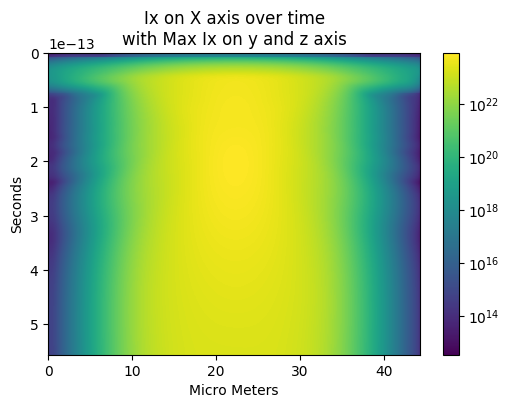

In [13]:
# plt.imshow(Ix_xAx_arr, interpolation='gaussian', extent=[0, 250*cell_x_coef, time_arr[-1], 0], aspect='auto')
plt.figure(dpi = 100)
plt.imshow(Ix_xAx_arr, interpolation='gaussian', extent=[0, 250*cell_x_coef*1e6, time_arr[-1], 0], aspect='auto', norm= LogNorm())
plt.title('Ix on X axis over time\nwith Max Ix on y and z axis')
plt.xlabel('Micro Meters')
plt.ylabel('Seconds')
plt.colorbar()

Text(0, 0.5, 'length - m')

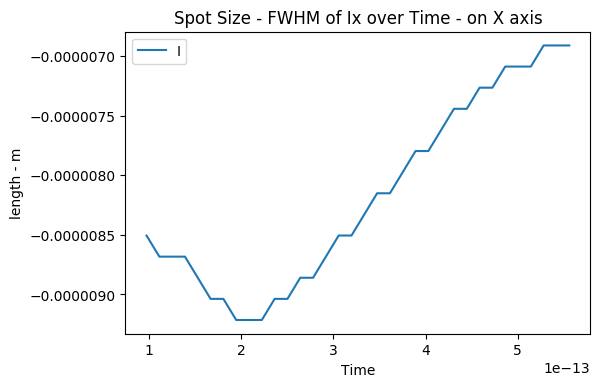

In [16]:
# ---------------- Full Width Half Maximum (FWHM) of [x,y,z] over time along the X Axis --------------------

fwhm_x_Xaxis_arr = []


for it in range(it_num_strt, iterations_done_so_far ):  
    fwhm_x_Xaxis_arr.append( getFWHM(Ix_xAx_arr[it])*cell_x_coef)

plt.figure(dpi=100)
        
plt.plot(time_arr[it_num_strt:], np.array(fwhm_x_Xaxis_arr))


plt.legend("Ix")
plt.title("Spot Size - FWHM of Ix over Time - on X axis")
plt.xlabel("Time")
plt.ylabel("length - m")


In [38]:
fft_data_arr = []
fft_fr_arr = []

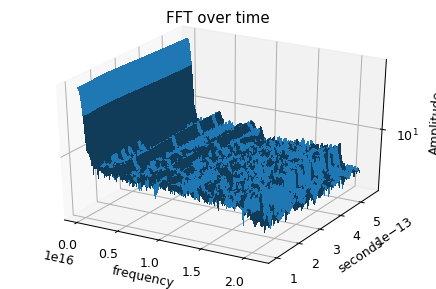

In [69]:
# -------------- Plot FFT Result over Time/Iteration -------------------

it_num_fftVis =  it_num_strt


fft_fr, fft_data = doFft(Ex_yAx_arr[it_num_fftVis], cells_y_size, cell_y_coef)

fft_fr_arr = np.array([fft_fr])
fft_data_arr = np.array([fft_data])

for it in range(it_num_fftVis + 1, iterations_done_so_far):
    fft_fr, fft_data = doFft(Ex_yAx_arr[it], cells_y_size,  cell_y_coef)
    fft_fr_arr = np.append(fft_fr_arr, [fft_fr], axis=0)    
    fft_data_arr = np.append(fft_data_arr, [fft_data], axis=0)
    
    fft_data_max = np.max(fft_data)
    fft_data_maxInd = np.argmax(fft_data) # and this equal to fft_fr max index
    fft_fr_max = fft_fr[fft_data_maxInd]
    fft_fr_max_arr.append(fft_fr_max)

    
y_ax_fft = time_arr[it_num_fftVis:]  
y_ax_fft, tmp = np.array(np.meshgrid(y_ax_fft, fft_fr_arr[1]))
y_ax_fft = np.transpose(y_ax_fft)     
    
fig = plt.figure(dpi = 90)
ax = fig.gca(projection = '3d')
ax.plot_surface(fft_fr_arr, y_ax_fft, np.log10(fft_data_arr),
                       linewidth=0, antialiased=False)

ax.set_xlabel('frequency')
ax.set_ylabel('seconds')
ax.set_zlabel('Amplitude')
ax.set_title('FFT over time')
ax.set_zscale('log')
